# AI Receipt Classifier Ensemble

This notebook implements a hybrid ML pipeline that extracts features from receipts using pretrained CNNs (ResNet34, EfficientNet-B0, MobileNetV2), trains XGBoost classifiers on these features, and combines their predictions via soft-voting to accurately detect whether a receipt is real or AI-generated, with evaluation metrics and single-image inference included.

# Import Machine Learning Models

In [ ]:
!pip install torch torchvision timm xgboost scikit-learn matplotlib seaborn

In [ ]:

import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import timm
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


# Define dataset path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/ INPUT DRIVE LOCATION"
folders = ["clean-total-legit", "clean-total-ai"]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print("cleaned-data exists:", os.path.exists(dataset_path))
print("Folders inside cleaned-data:", os.listdir(dataset_path))


cleaned-data exists: True
Folders inside cleaned-data: ['clean-total-legit', 'clean-total-ai', 'eveyrthing-must-be-jpg.txt']


#  Image preprocessing


In [ ]:
image_size = 224  # standard input size
transform = transforms.Compose([
  transforms.Resize((image_size, image_size)),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])

# Load dataset


In [ ]:
# Create a unified dataset with labels: 0 = legit, 1 = AI
data = []
labels = []

for idx, folder in enumerate(folders):
    folder_path = os.path.join(dataset_path, folder)
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        data.append(img_path)
        labels.append(idx)

print(f"Total images: {len(data)}")

Total images: 736


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

labels = np.array(labels)

data_train, data_test, y_train, y_test = train_test_split(
    data,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

print("Training samples:", len(data_train))
print("Test samples:", len(data_test))


Training samples: 588
Test samples: 148


# Helper function: load and preprocess image


In [ ]:
from PIL import Image

def load_image(path):
    img = Image.open(path).convert("RGB")
    return transform(img).unsqueeze(0)  # add batch dim

#  Define CNN models (pretrained)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn_models = {
    "resnet34": models.resnet34(pretrained=True),
    "efficientnet_b0": models.efficientnet_b0(pretrained=True),
    "mobilenet_v2": models.mobilenet_v2(pretrained=True)
}

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 249MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 159MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 110MB/s] 


In [ ]:
# Remove final classifier layers, keep feature extractor
for name, model in cnn_models.items():
    model = model.to(device)
    model.eval()
    if "resnet" in name:
        cnn_models[name] = nn.Sequential(*list(model.children())[:-1])
    elif "efficientnet" in name or "mobilenet" in name:
        cnn_models[name] = nn.Sequential(*list(model.children())[:-1])


# Extract features for all images


In [ ]:
def extract_features(model, data):
    features = []
    with torch.no_grad():
        for path in data:
            img_tensor = load_image(path).to(device)
            feat = model(img_tensor)
            feat = feat.view(feat.size(0), -1)  # flatten
            features.append(feat.cpu().numpy()[0])
    return np.array(features)

In [ ]:
features_train_dict = {}
features_test_dict = {}

for name, model in cnn_models.items():
    print(f"Extracting features from {name}...")
    features_train_dict[name] = extract_features(model, data_train)
    features_test_dict[name] = extract_features(model, data_test)


Extracting features from resnet34...
Extracting features from efficientnet_b0...
Extracting features from mobilenet_v2...


# Train XGBoost classifier per model


In [ ]:
import xgboost as xgb

xgb_models = {}

for name in cnn_models.keys():
    print(f"Training XGBoost for {name} features...")
    model = xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=1  # optional: handle imbalance
    )
    model.fit(features_train_dict[name], y_train)  # train on train features
    xgb_models[name] = model


Training XGBoost for resnet34 features...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:42:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training XGBoost for efficientnet_b0 features...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:42:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training XGBoost for mobilenet_v2 features...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:42:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Ensemble prediction (soft voting)


In [ ]:
# Initialize array to hold summed probabilities
probs = np.zeros((len(y_test), 2))  # 2 classes: real vs AI/fake

# Add probabilities from each XGBoost model
for name, model in xgb_models.items():
    probs += model.predict_proba(features_test_dict[name])  # use test features

# Average probabilities
probs /= len(xgb_models)

# Final predicted labels
y_pred = np.argmax(probs, axis=1)


# Evaluate


Ensemble Accuracy: 99.32%


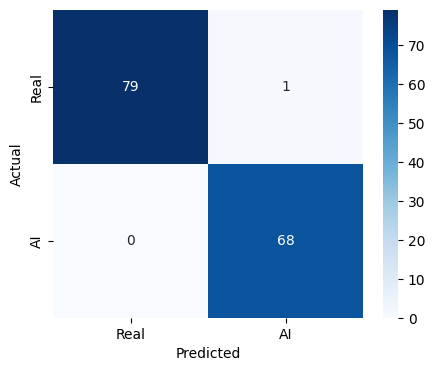

              precision    recall  f1-score   support

        Real       1.00      0.99      0.99        80
     AI/Fake       0.99      1.00      0.99        68

    accuracy                           0.99       148
   macro avg       0.99      0.99      0.99       148
weighted avg       0.99      0.99      0.99       148



In [ ]:
# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Ensemble Accuracy: {acc*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'AI'], yticklabels=['Real', 'AI'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=['Real', 'AI/Fake']))

# TRY AND UPLOAD NEW PHOTO


In [ ]:
def predict_image_class(image_path):
    # Preprocess the image
    img_tensor = load_image(image_path).to(device)

    # Extract features using the same CNNs
    test_features_dict = {}
    for name, model in cnn_models.items():
        with torch.no_grad():
            feat = model(img_tensor)
            feat = feat.view(feat.size(0), -1)  # flatten
            test_features_dict[name] = feat.cpu().numpy()

    # Get predictions from each XGBoost model
    probs = np.zeros(2)  # 2 classes: Real vs AI/Fake

    for name, xgb_model in xgb_models.items():
        probs += xgb_model.predict_proba(test_features_dict[name])[0]  # [0] because single sample

    # Average probabilities (soft voting)
    probs /= len(xgb_models)

    # Final prediction
    class_idx = np.argmax(probs)
    class_names = ['Real', 'AI/Fake']

    print(f"Prediction for {image_path}: {class_names[class_idx]}")
    print(f"Probabilities - Real: {probs[0]:.2f}, AI/Fake: {probs[1]:.2f}")

Prediction for /content/drive/MyDrive/ML-Samples/try-test/03.jpg: AI/Fake
Probabilities - Real: 0.00, AI/Fake: 1.00


### Example usage with the function


In [ ]:
# AI
new_image_path = "/content/drive/MyDrive/ INPUT DRIVE LOCATION"
predict_image_class(new_image_path)

# REAL
new_image_path = "/content/drive/MyDrive/ INPUT DRIVE LOCATION"
predict_image_class(new_image_path)

Prediction for /content/drive/MyDrive/ML-Samples/try-test/01-ai.jpg: AI/Fake
Probabilities - Real: 0.00, AI/Fake: 1.00
Prediction for /content/drive/MyDrive/ML-Samples/try-test/01-real.jpg: Real
Probabilities - Real: 0.95, AI/Fake: 0.05


# WHOLE PYTHON PIPELINE

In [ ]:
# 1️⃣ Install / Import Dependencies
!pip install torch torchvision timm xgboost scikit-learn matplotlib seaborn

import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import timm
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 2️⃣ Define dataset path
dataset_path = "/content/drive/MyDrive/ INPUT DRIVE LOCATION"  # mount Google Drive first
folders = ["combined-total-legit", "combined-total-ai"]  # your folders

# 3️⃣ Image preprocessing
image_size = 224  # standard input size
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 4️⃣ Load dataset
# Create a unified dataset with labels: 0 = legit, 1 = AI
data = []
labels = []

for idx, folder in enumerate(folders):
    folder_path = os.path.join(dataset_path, folder)
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        data.append(img_path)
        labels.append(idx)

print(f"Total images: {len(data)}")

# 5️⃣ Helper function: load and preprocess image
from PIL import Image

def load_image(path):
    img = Image.open(path).convert("RGB")
    return transform(img).unsqueeze(0)  # add batch dim

# 6️⃣ Define CNN models (pretrained)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn_models = {
    "resnet34": models.resnet34(pretrained=True),
    "efficientnet_b0": models.efficientnet_b0(pretrained=True),
    "mobilenet_v2": models.mobilenet_v2(pretrained=True)
}

# Remove final classifier layers, keep feature extractor
for name, model in cnn_models.items():
    model = model.to(device)
    model.eval()
    if "resnet" in name:
        cnn_models[name] = nn.Sequential(*list(model.children())[:-1])
    elif "efficientnet" in name or "mobilenet" in name:
        cnn_models[name] = nn.Sequential(*list(model.children())[:-1])

# 7️⃣ Extract features for all images
def extract_features(model, data):
    features = []
    with torch.no_grad():
        for path in data:
            img_tensor = load_image(path).to(device)
            feat = model(img_tensor)
            feat = feat.view(feat.size(0), -1)  # flatten
            features.append(feat.cpu().numpy()[0])
    return np.array(features)

features_dict = {}
for name, model in cnn_models.items():
    print(f"Extracting features from {name}...")
    features_dict[name] = extract_features(model, data)

# 8️⃣ Train XGBoost classifier per model
from sklearn.model_selection import train_test_split

X_train_dict, X_test_dict, y_train, y_test = {}, {}, train_test_split(labels, labels, test_size=0.2, random_state=42)

# Since features_dict[name] is array, split features
for name in cnn_models.keys():
    X_train_dict[name], X_test_dict[name], y_train, y_test = train_test_split(features_dict[name], labels, test_size=0.2, random_state=42)

xgb_models = {}
for name in cnn_models.keys():
    print(f"Training XGBoost for {name} features...")
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train_dict[name], y_train)
    xgb_models[name] = model

# 9️⃣ Ensemble prediction (soft voting)
probs = np.zeros((len(y_test), len(folders)))  # num_samples x num_classes

for name, model in xgb_models.items():
    probs += model.predict_proba(X_test_dict[name])

probs /= len(xgb_models)  # average probabilities
y_pred = np.argmax(probs, axis=1)

# 10️⃣ Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"Ensemble Accuracy: {acc*100:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=folders, yticklabels=folders)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
